# Universal Pleasantness

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from copy import copy
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
from tqdm.auto import tqdm
sns.set(font_scale=1.2)
import univple as up

## Load the data and show the ranking for each odorant

In [ ]:
data = {}
data['raw'], odorants = up.load_data()
groups, group_ids = up.get_groups(data['raw'])
data['raw'].head()  # First 5 rows

## Figure 1: N/A (Created externally)

## Figure 2: Raw Data and Summary

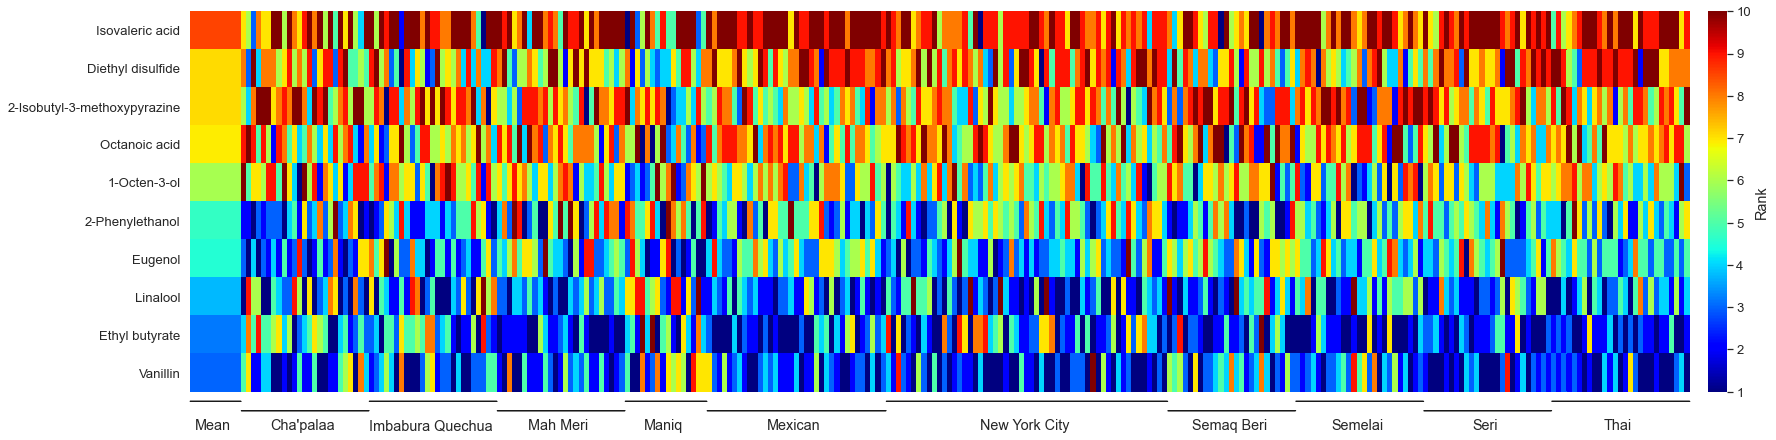

In [3]:
plt.figure(figsize=(32, 7))

# Rank by mean valence
odorants_by_valence = data['raw'].mean().sort_values().index

# Arrange data with mean in the first row
z = data['raw'][odorants_by_valence[::-1]]
mean = z.mean()
mean.name = 'Mean'
mean = mean.to_frame()
mean.name = 'mean'
n_mean = 10
z = pd.concat([mean.T]*n_mean + [z])

ax = sns.heatmap(z.T, xticklabels=[], cmap='jet', cbar_kws={'pad': 0.01, 'label': 'Rank', 'ticks':range(11)})
ax.set_xlabel('')
ax.set_ylabel('')
group_ranges = {'Mean': np.arange(n_mean)}
for group in groups:
    group_ranges[group] = data['raw'].reset_index().query(f'Group=="{group}"').index.values+n_mean
for i, (group, range_) in enumerate(group_ranges.items()):
    ax.text(range_.mean(), 11, group, horizontalalignment='center')
    #line = lines.Line2D(x, y, lw=5., color='r', alpha=0.4)
    ax.arrow(range_.min(), 10.25+0.25*(i%2), range_.max() + 1 - range_.min(), 0, clip_on=False, color='k', length_includes_head=True)

Figure 2: Summary of pleasantness rankings across individuals and cultures.  Between n=16 and n=35 individuals from each culture ranked each of 10 odorants in order from most (1, blue) to least (10, red) pleasant.  Each color patch represents the integer ranking that one individual (from the culture indicated at the bottom) to one odorant (indicated on the left).  The broad column on the far left represents the average ranking for each odorant across all individuals shown here.

### Fig. S1: Comparison of highest-ranked and lowest-ranked odorants in each culture

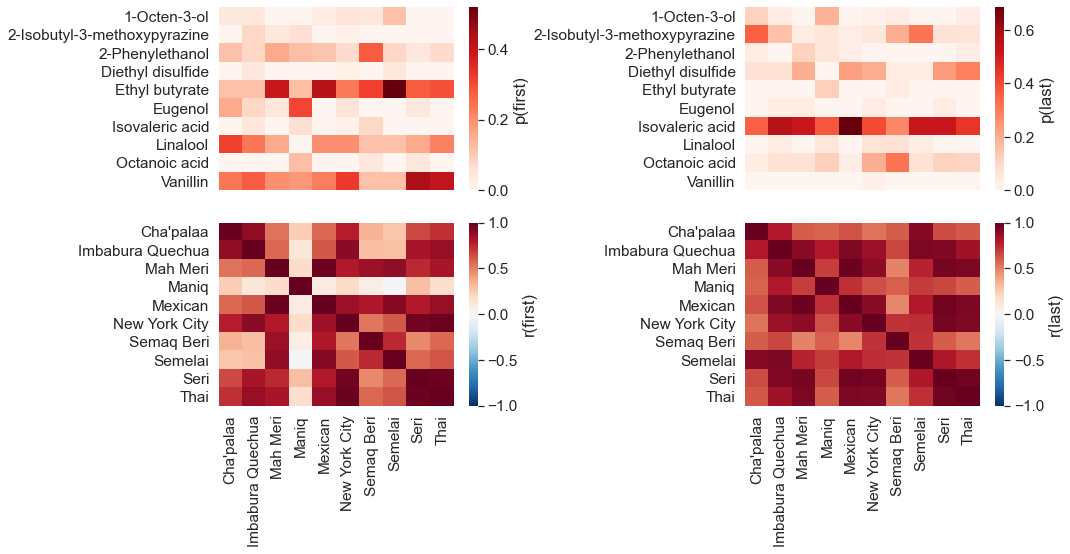

In [31]:
up.fig_highest_lowest(data['ranked'], groups, odorants)

Figure S1: Pleasantness rankings are correlated for both the most pleasant and most unpleasant odorants.  (A) Fraction of individuals within each culture that ranked the given odorant as the most pleasant of the 10.  (B) Same as A, but for the least pleasant odorant.  (C) Correlation matrix computed from panel A; this shows correlation between cultures in the number of individuals that rated each odorant as the most pleasant.  (D) Same as C but showing a correlation matrix computed from B, for the least pleasant odorants.

## Figure 3: Effect size for each of the major factors

In [ ]:
### Fit ANOVA model for current dataset and for counterfactual datasets under different hypotheses:
# - OWC: Within-culture agreement is the same, but across-culture agreement is random. Create a unique ranking shuffle for each group and apply each group's shuffle identically to the members of that group
# - I: Culture is not a predictive label.  Shuffle individuals between cultures.
eta2_mean, eta2_sd = up.get_eta2(data['raw'])

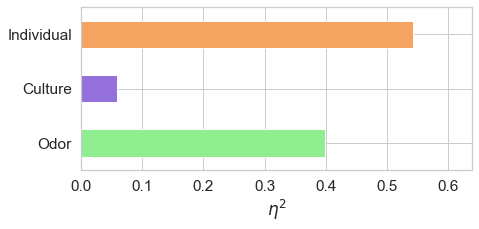

In [109]:
# Effect size for each major factor
up.fig_eta2(eta2_mean, eta2_sd, simplify=True)

Figure 3: Effect size $\eta^2$ from a two-way ANOVA for each of three factors that could potentially explain each individual's pleasantness rankings: Individual preferences (orange), Culture membership (purple), and Odor identity (green).  Effect sizes sum to 1, so culture contributed only $\sim6\%$ to the rankings given by each individual.

### Figure S2: Controls for Figure 3

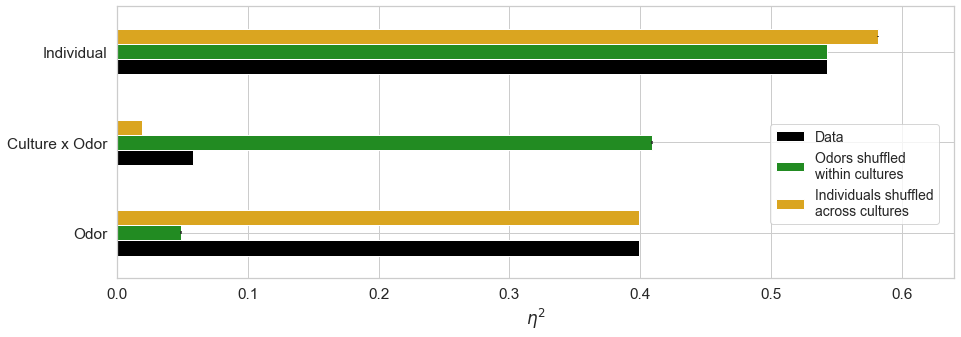

In [121]:
up.fig_eta2(eta2_mean, eta2_sd)

Figure S2: Similar to Figure 3, but showing a positive and negative control to demonstrate that alternative scenarios would have been detected using this design.  The black bars correspond to the actual data.  The green bars correspond to a a culture-specific shuffling of odorant labels applied to each individual (positive control).  The orange bars correspond to a shuffling of culture labels across individuals (negative control).

In [ ]:
# Same as above as a table
eta2_mean.round(3)

### Figure 4: Cultures for Individuals and Model vs Individuals

In [ ]:
# Compute the Kendall-Tau correlation among the various sets of rankings
model_predictions = up.get_model_predictions(odorants)
taus = up.compute_kendall_taus(data['raw'], model_predictions)

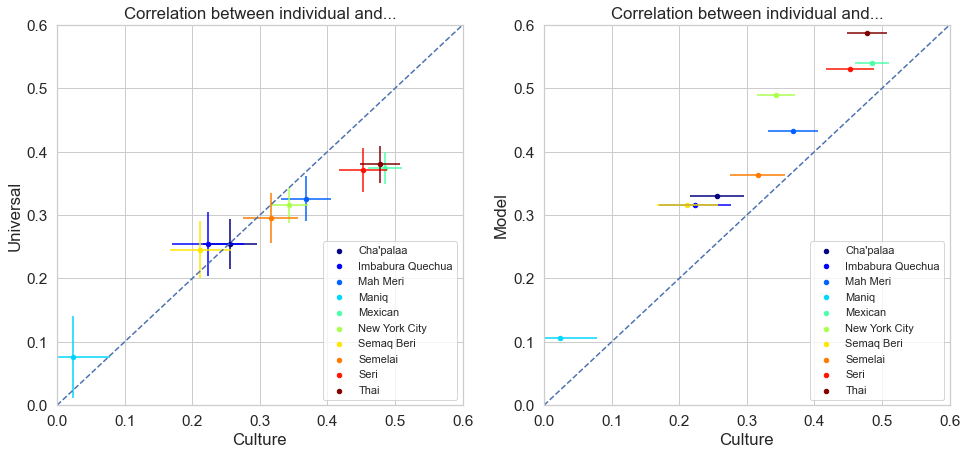

In [128]:
up.fig_kendall_tau(taus, groups)

Figure 4: A universal model for odor pleasantness performs as well as a culture-specific one.  (A) The correlation of odor pleasantness rankings (Kendall's $\tau$) between each individual and other individuals from their culture (x-axis) is similar to the correlation between each individual and the entire population studied here.  (B) Rankings predicted by a computational model trained on perceived pleasantness ratings for out-of-sample odorants are more correlated with individual rankings for the odorants used here than are other individuals from the same culture.

### Fig. S3: Intensity Controls

In [ ]:
data['intensity_ranked'] = pd.read_csv('data/All data intensity.txt', sep='\t')
data['intensity_ranked'] = data['intensity_ranked'].rename(columns={'Participant number ': 'Participant', 'Language/Group': 'Group'}).set_index(['Group', 'Participant'])
data['intensity_ranked'].columns.name = 'Rank'
data['intensity_ranked'].columns = range(1, 11) # 1 is the highest-ranked intensity
data['intensity_ranked']

In [ ]:
data['intensity'] = data['intensity_ranked'].apply(np.argsort, axis=1)+1
data['intensity'].columns = odorants
data['intensity']

In [ ]:
# Pleasantness vs Intensity
taus_pi = get_kt(data['raw'], data['intensity'])

In [ ]:
# Pleasantness vs Pleasantness
taus_pp = get_kt(data['raw'], data['raw'])

In [ ]:
# Intensity vs Intensity
taus_ii = get_kt(data['intensity'], data['intensity'])

Tau Same Culture: -0.024 +/- 0.022
Tau Different Culture: -0.025 +/- 0.039
Tau Same Culture: 0.32 +/- 0.14
Tau Different Culture: 0.27 +/- 0.12
Tau Same Culture: 0.24 +/- 0.024
Tau Different Culture: 0.17 +/- 0.044


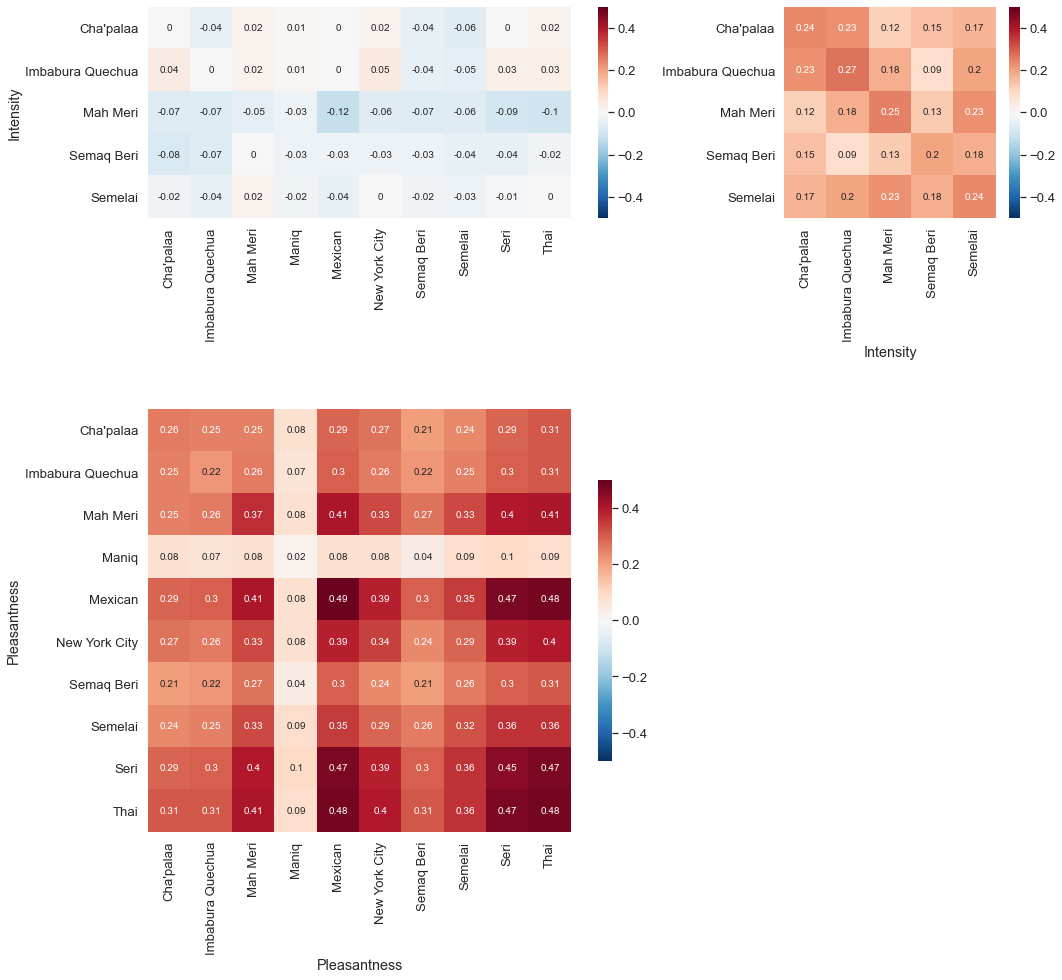

In [211]:
up.fig_intensity_control(taus_pi, taus_pp, taus_ii)

Figure S3: The correlations across cultures in pleasantness rankings are not explained by perceived intensity.  (A) Rank correlations (Kendall's $\tau$) between individuals of the ranked pleasantness of the 10 odorants (x-axis) and the ranked intensity of the 10 odorants (y-axis) were computed, and the mean $\tau$ reported for such pairs of individuals within and across cultures. Such correlations were consistenly near zero and not significant. Note that intensity data was collected in only some cultures, and from a novel set of individuals. (B) The correlation between individuals for intensity alone was significantly positive, suggesting a "universal intensity" factor that is indepenent of pleasantness. (C) The correlation for between individuals for pleasantness alone is positive and signficiantly greater than that observed for intensity.  In all panels, comparisons between and individual and themselves were excluded.